# Bleach corrections evaluation
this notebook evaluate different bleach correction methods
- single exponential fit
- double exponential fit
- different regressions (robust)

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import pynapple as nap

import matplotlib.pyplot as plt

import iblphotometry.preprocessing
import iblphotometry.plots

from utils import * # don't

from one.api import ONE

one = ONE(base_url="https://alyx.internationalbrainlab.org")

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 166

%load_ext autoreload
%autoreload 2

In [3]:
# select and load dataset
eid = "974a8a32-2156-4250-b9db-4298fc8daa65"
data_path = Path("/home/georg/data_local/raw_photometry_NE.pqt")
trials = one.load_dataset(eid, "alf/task_00/_ibl_trials.table.pqt")

# load trial data
raw_photometry = pd.read_parquet(data_path)
raw_photometry = nap.TsdFrame(raw_photometry.set_index("times"))

# restricting the fluorescence data to the time within the task +-1s
t_start = trials.iloc[0]["intervals_0"] - 1
t_stop = trials.iloc[-1]["intervals_1"] + 1
session_interval = nap.IntervalSet(t_start, t_stop)
raw_photometry = raw_photometry.restrict(session_interval)



In [10]:
F = raw_photometry['raw_calcium']
y, t = F.values, F.times()

from bleach_corrections import ExponDecayBleachingModel, DoubleExponDecayBleachingModel

bleaching_model = ExponDecayBleachingModel(method='L-BFGS-B')
F_corr = bleaching_model.bleach_correct(F)
# fig, axes = plt.subplots()
# axes.plot(F)

print(bleaching_model.calc_model_stats(F, use_kde=False, n_samples=-1))



fitting using L-BFGS-B
{'r_sq': 0.9062994760779263, 'll': 1754190.892621882, 'aic': -22.755036557460176}
[3.49780679e-05 1.72255059e+03 3.92938795e-03]


0.9062994760779263

fitting using L-BFGS-B
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.0798745870978684e-06
        x: [ 1.866e-05  1.723e+03  1.843e-05  8.613e+02  3.931e-03]
      nit: 14
      jac: [-8.385e-05 -4.756e-11 -4.888e-05  1.197e-10 -7.382e-05]
     nfev: 96
     njev: 16
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
{'r_sq': 0.921180775335886, 'll': 1767569.1958776389, 'aic': -18.770231649995914}
[1.86637127e-05 1.72255059e+03 1.84283267e-05 8.61275294e+02
 3.93149613e-03]


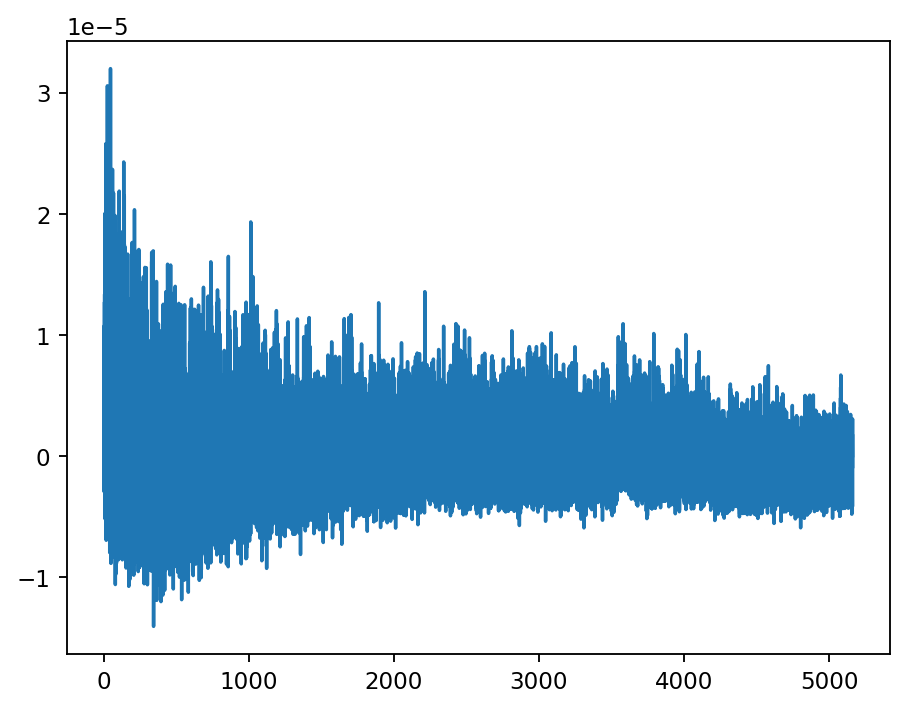

In [11]:

bleaching_model = DoubleExponDecayBleachingModel()
F_corr = bleaching_model.bleach_correct(F)
print(bleaching_model.minimize_result)

fig, axes = plt.subplots()
axes.plot(F_corr)
print(bleaching_model.calc_model_stats(F, use_kde=False, n_samples=-1))
print(bleaching_model.popt)


In [ ]:

# bleaching_model = DoubleExponDecayBleachingModel()
# _ = bleaching_model.bleach_correct(F)
# print(bleaching_model.calc_model_stats(F, use_kde=False, n_samples=-1))